## Урок 6. Градиентный бустинг (AdaBoost)

1. Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

Используем один из "игрушечных" датасетов из той же библиотеки.

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [7]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [8]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

__Теперь обучим несколько моделей с разным числом деревьев в ансамбле.__

In [9]:
# Число деревьев в ансамбле
n_trees = [_ for _ in range(1, 16)]

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.1

train_errors_list = []
test_errors_list = []

for n_tree in n_trees:
    # для простоты примем коэффициенты равными 1
    coefs = [1] * n_tree
    trees, train_errors, test_errors = gb_fit(n_tree, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_errors_list.append(train_errors)
    test_errors_list.append(test_errors)

In [10]:
# функция построения графика зависимости ошибки от количества деревьев в ансамбле
def get_tree_num_plot(n_trees, train_err, test_err):
    plt.xlabel('Tree number')
    plt.ylabel('MSE')
    plt.plot(n_trees, train_err, label='train error')
    plt.plot(n_trees, test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

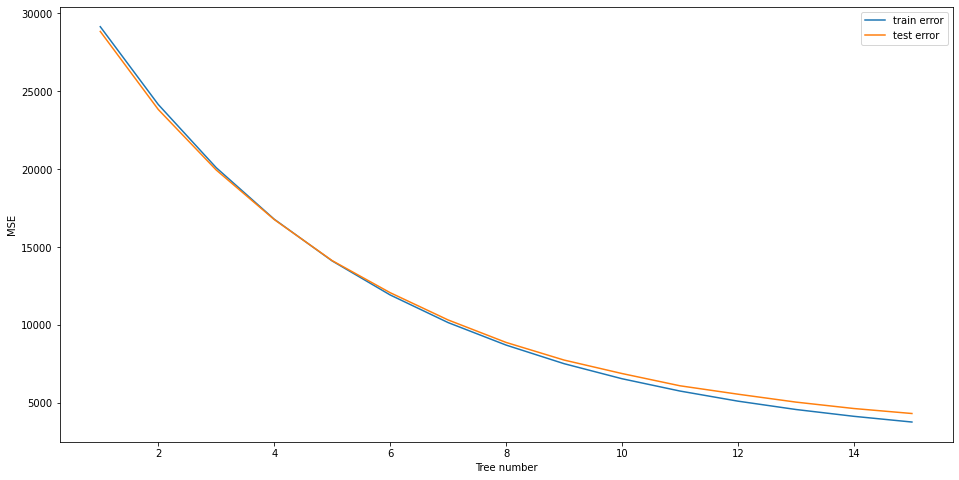

In [11]:
plt.figure(figsize=(16,8))
get_tree_num_plot(n_trees, train_errors_list[-1], test_errors_list[-1])

Ошибки уменьшаются по мере увеличения кол-ва деревьев в ансамбле и пересекаются на графике в районе числа 9, при чем при увеличении шага (eta) кол-во деревьев в ансамбле можно уменьшать, т.к ошибки уменьшаются быстрее. Далее сохраняется уменьшение ошибок, но на тренировочной выборке оно идет более быстро чем на тестовой.

__Теперь поэкспериментируем с глубиной дерева__

In [12]:
# Число деревьев в ансамбле, возьмем 2
n_trees = 12
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = [_ for _ in range(1, 16)]

# Шаг
eta = 0.1

train_errors_depth_list = []
test_errors_depth_list = []
for depth in max_depth:
    trees, train_errors, test_errors = gb_fit(n_trees, depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_errors_depth_list.append(train_errors[-1])
    test_errors_depth_list.append(test_errors[-1])

In [13]:
# функция построения графика зависимости ошибки от максимальной глубины деревьев
def get_depth_plot(max_depth, train_err, test_err):
    plt.xlabel('Max depth')
    plt.ylabel('MSE')
    plt.plot(max_depth, train_err, label='train error')
    plt.plot(max_depth, test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

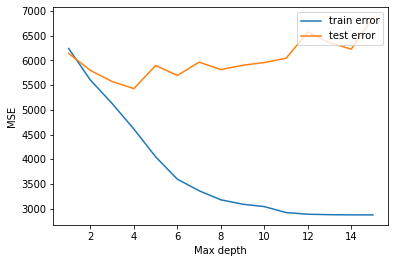

In [14]:
get_depth_plot(max_depth, train_errors_depth_list, test_errors_depth_list)

Оптимальная глубина деревьев, исходя из графика, лежит в районе значения 2. Далее идет переобучение.